# 1.**Environment**

In [ ]:
# basic settings
!pip install timm
!pip install adversarial-robustness-toolbox
!pip install timm foolbox

     |████████████████████████████████| 296kB 5.6MB/s 
     |████████████████████████████████| 972kB 5.8MB/s 
     |████████████████████████████████| 3.4MB 59.1MB/s 
     |████████████████████████████████| 235kB 61.1MB/s 
     |████████████████████████████████| 21.6MB 92.9MB/s 
     |████████████████████████████████| 25.3MB 1.3MB/s 
     |████████████████████████████████| 747kB 58.2MB/s 
  Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2
     |████████████████████████████████| 1.7MB 5.8MB/s 
     |████████████████████████████████| 163kB 63.8MB/s 
     |████████████████████████████████| 61kB 9.1MB/s 
     |████████████████████████████████| 71kB 10.4MB/s 
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 h

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# drive.flush_and_unmount()
!pwd

Mounted at /content/drive
/content


# 2.Setup

In [ ]:
# For Vit importing
import timm

# For ViT examples
import urllib
from PIL import Image
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

# General + imagenet dataloader
from __future__ import print_function, division
import torchvision
from torchvision import datasets, models, transforms
import os
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import time 
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

plt.ion()   # interactive mode

# ART lib
from art.attacks.evasion import FastGradientMethod, DeepFool
from art.estimators.classification import PyTorchClassifier
from art.utils import load_mnist

# Progress bar
# Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
# from tqdm import tqdm_notebook as tqdm
from tqdm.notebook import tqdm

# foolbox
from foolbox import PyTorchModel, accuracy, samples
from foolbox.attacks import L2CarliniWagnerAttack, LinfPGD, LinfFastGradientAttack, L2PGD
import foolbox as fb


# 3. Utils & Config

In [ ]:
def convert_1hot(data, num_classes=100):
  rows = len(data)
  cols = num_classes
  new_data = np.zeros((rows,cols))
  for idx, i in enumerate(data):
    new_data[idx,i] = 1
  return new_data


def count_parameters(model):
  num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
  print("The model has {} parameters".format(num_params))
  return num_params

def clear_pytorch_cache():
  torch.cuda.empty_cache()


def train_model(model, criterion, optimizer, scheduler, dataloaders, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


def show_cached_memory():
  print("Memory cached : {} MB".format(torch.cuda.memory_cached() / 1024**2))


# save image to folders
def save_adv_images(inputs, clipped_advs, labels, model, dirpath=""):

  dir = dirpath
  if len(dirpath) == "":
    timestr = time.strftime("%Y%m%d-%H%M%S")
    dirpath = os.path.join("/content/drive/MyDrive/598dataset", timestr)

  
  # try to create the dir
  os.makedirs(dir, exist_ok=True)

  # loop over images and save adv results
  clean_preds = model(inputs).argmax(axis=1)
  adv_preds = model(clipped_advs).argmax(axis=1)
  norm = ((inputs - clipped_advs)**2).sum(axis=(1, 2, 3))**0.5
  norm = norm.cpu().numpy().round(2)

  # remember dir count
  filenum_counter = {}

  for i in range(inputs.shape[0]):

    adv_img = clipped_advs[i].cpu().numpy()
    adv_img = adv_img.swapaxes(0, 1)
    adv_img = adv_img.swapaxes(1, 2)

    # get labels and predictions
    label = class_names[int(labels[i])]
    clean_pred = class_names[int(clean_preds[i])]
    adv_pred = class_names[int(adv_preds[i])]
    img_dir = os.path.join(dir, str(label))

    if img_dir not in filenum_counter:
      os.makedirs(img_dir, exist_ok=True)
      filenum_counter[img_dir] = len(os.listdir(img_dir)) + 1
    else:
      filenum_counter[img_dir] += 1

    # image name
    img_name = "img{}_clean{}_adv{}_L2diff{}.png".format(filenum_counter[img_dir], clean_pred, adv_pred, norm[i])
    img_path = os.path.join(img_dir, img_name)

    # save the image
    print(adv_img.max(), adv_img.min(), adv_img.shape)
    plt.imsave(img_path, adv_img)

    # load the image and test

    

def torch_batch_to_img_array(batch):

  # render into numpy
  if str(type(batch)) == "<class 'list'>":
    batch = batch[0]
  
  # if 
  # batch = batch.cpu().numpy()


In [ ]:
NUM_CLASSES = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 4.Models

## 4.0 Dataloaders

In [ ]:
# clear the cache
clear_pytorch_cache()

# Load imagenet tiny, transformer in validation set enabled
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/598dataset/tinyImageNet/TinyImageNet'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, "tiny_"+x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
                  
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4, pin_memory=True)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# get some constants
NUM_CLASSES = len(class_names)


## 4.1 VIT

### 4.1.0 Load the pretrianed vit model

In [ ]:
# load pre-trained vit
model = timm.create_model('vit_base_patch16_224', pretrained=True)

# For information about the implementation see here: https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py

for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.head.in_features
model.head = nn.Linear(num_ftrs, NUM_CLASSES)
criterion = nn.CrossEntropyLoss()

# only parameters from the last layer is updated
optimizer_vit = optim.SGD(model.head.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_vit, step_size=7, gamma=0.1)


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_p16_224-80ecf9dd.pth" to /root/.cache/torch/hub/checkpoints/jx_vit_base_p16_224-80ecf9dd.pth


In [ ]:
model.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (

### 4.1.1 (option1) Vit Fine-tuning

In [ ]:
# # Finetune starts
# model.to(device)
# model_fine_tuned = train_model(model, criterion, optimizer_vit, exp_lr_scheduler, dataloaders, num_epochs=25)

# # save the model
# torch.save(model.state_dict(), '/content/drive/MyDrive/598dataset/ViTbase_16_224_tiny_15classes.pth')


### 4.1.1 (option2) model loading

In [ ]:
model_state_path = '/content/drive/MyDrive/598dataset/ViTbase_16_224_tiny_15classes.pth'


model_state_path = '/content/drive/MyDrive/598dataset/ViTbase_16_224_tiny_15classes_adv_c&wl2_epsilon0.3.pth'
model_state_path = '/content/drive/MyDrive/598dataset/ViTbase_16_224_tiny_15classes_adv_fgsm_epsilon0.01.pth'
model.load_state_dict(torch.load(model_state_path))
model.eval()





VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (

## 4.2 ResNet50

In [ ]:
# Finetune CNN ResNet-50
model_cnn = models.resnet50(pretrained=True, progress=True)

model_cnn.fc = nn.Linear(model_cnn.fc.in_features, NUM_CLASSES)
model_cnn = model_cnn.to(device)
params_to_update = model_cnn.parameters()

# # Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_cnn.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
# # Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
# model_cnn = train_model(model_cnn, criterion, optimizer_ft,exp_lr_scheduler, dataloaders, num_epochs=25)
# torch.save(model_cnn.state_dict(), '/content/drive/MyDrive/598dataset/ResNet50_tinyImgNet.pth')

# load the model
model_cnn.load_state_dict(torch.load('/content/drive/MyDrive/598dataset/ResNet50_tinyImgNet.pth'))


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


<All keys matched successfully>

# 5. Attack

## 5.0 setup

In [ ]:
# load the data
# clear the cache
clear_pytorch_cache()

# Load imagenet tiny, transformer in validation/train set disabled
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/598dataset/tinyImageNet/TinyImageNet'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, "tiny_"+x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
                  
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4, pin_memory=True)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# get some constants
NUM_CLASSES = len(class_names)


In [ ]:
def test_attack(attack, epsilons, fmodel, dataloaders, img_save_dir="", save_train=False):
  count = 0
  running_acc = torch.zeros(len(epsilons)).to(device)

  # Vlidation set
  with tqdm(dataloaders['val'], unit='batch') as tepoch:
    for inputs, labels in tepoch:
      inputs = inputs.to(device)
      labels = labels.to(device)
      raw_advs, clipped_advs, success = attack(fmodel, inputs, labels, epsilons=epsilons)

      # save images
      if img_save_dir:
        for idx in range(len(clipped_advs)):
          dirname = "Epsilon{}".format(epsilons[idx]) + "/val"
          save_adv_images(inputs, clipped_advs[idx], labels, fmodel, dirpath=os.path.join(img_save_dir, dirname))

      running_acc += 1 - success.float().mean(axis=-1)
      count += 1

  # report accuracy on val dataset
  running_acc /= count
  for eps, acc in zip(epsilons, running_acc):
      print(f"  Linf norm ≤ {eps:<6}: {acc.item() * 100:4.1f} %")
  
  # save train adv
  if save_train:
    with tqdm(dataloaders['train'], unit='batch') as tepoch:
      for inputs, labels in tepoch:
        inputs = inputs.to(device)
        labels = labels.to(device)
        raw_advs, clipped_advs, success = attack(fmodel, inputs, labels, epsilons=epsilons)

        # save images
        if img_save_dir:
          for idx in range(len(clipped_advs)):
            dirname = "Epsilon{}".format(epsilons[idx]) + "/train"
            save_adv_images(inputs, clipped_advs[idx], labels, fmodel, dirpath=os.path.join(img_save_dir, dirname))



## 5.1 VIT

### 5.1.1 VIT clean model accuracy

In [ ]:
# clean model accuracy
model.eval()
preprocessing = dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], axis=-3)
fmodel = PyTorchModel(model, bounds=(0, 1), preprocessing=preprocessing)

count = 0
running_acc = 0

clear_pytorch_cache()
show_cached_memory()
with tqdm(dataloaders['val'], unit='batch') as tepoch:
  for inputs, labels in tepoch:
    inputs = inputs.to(device)
    labels = labels.to(device)
    running_acc += accuracy(fmodel, inputs, labels)
    count += 1

print(f"clean accuracy:  {running_acc/count * 100:.1f} %")


### 5.1.2 L_inf white-box attack

#### 5.1.2.1 FGSM

In [ ]:
# FGSM, Linf
attack = LinfFastGradientAttack()
epsilons = [
    0.001,
    0.005,
    0.01,
    0.1
]
img_save_dir = '/content/drive/MyDrive/598dataset/TinyImgNet_AdvSamples/VIT/FGSM'

# Note that for the training dir to be saved, normalization should be disabled
test_attack(attack, epsilons, fmodel, dataloaders, img_save_dir, save_train=True)


  Linf norm ≤ 0.001 : 65.7 %
  Linf norm ≤ 0.005 : 33.6 %
  Linf norm ≤ 0.01  : 25.3 %
  Linf norm ≤ 0.1   : 12.6 %


In [ ]:
### debug cell
# FGSM, Linf
attack = LinfFastGradientAttack()
epsilons = [
    0.001,
    0.005,
    0.01,
    0.1
]
img_save_dir = '/content/drive/MyDrive/598dataset/TinyImgNet_AdvSamples/Debug/FGSM_1312'

# Note that for the training dir to be saved, normalization should be disabled
test_attack(attack, epsilons, fmodel, dataloaders, img_save_dir, save_train=False)

#### 5.1.2.2 PGD (L inf)

In [ ]:
# Linf PGD
attack = LinfPGD()
epsilons = [
    0.001,
    0.005,
    0.01,
    0.1
]

img_save_dir = '/content/drive/MyDrive/598dataset/TinyImgNet_AdvSamples/VIT/PGD_Linf'
test_attack(attack, epsilons, fmodel, dataloaders, img_save_dir, save_train=True)




  Linf norm ≤ 0.001 : 60.7 %
  Linf norm ≤ 0.005 :  7.6 %
  Linf norm ≤ 0.01  :  0.2 %
  Linf norm ≤ 0.1   :  0.0 %


### 5.1.3 L2 white-box

#### 5.1.3.1 PGD (L2)

In [ ]:
# L2 PGD, Epsilons need to be larger
attack = L2PGD()
epsilons = [
    80
]

img_save_dir = '/content/drive/MyDrive/598dataset/TinyImgNet_AdvSamples/VIT/PGD_L2'
test_attack(attack, epsilons, fmodel, dataloaders, img_save_dir, save_train=False)

1.0 0.0 (224, 224, 3)
1.0 0.0 (224, 224, 3)
1.0 0.0 (224, 224, 3)
1.0 0.0 (224, 224, 3)
1.0 0.0 (224, 224, 3)
1.0 0.0 (224, 224, 3)
1.0 0.0 (224, 224, 3)
1.0 0.0 (224, 224, 3)
1.0 0.0 (224, 224, 3)
1.0 0.0 (224, 224, 3)
1.0 0.0 (224, 224, 3)
1.0 0.0 (224, 224, 3)
1.0 0.0 (224, 224, 3)
1.0 0.0 (224, 224, 3)
1.0 0.0 (224, 224, 3)
1.0 0.0 (224, 224, 3)
1.0 0.0 (224, 224, 3)
1.0 0.0 (224, 224, 3)
1.0 0.0 (224, 224, 3)
1.0 0.0 (224, 224, 3)
1.0 0.0 (224, 224, 3)
1.0 0.0 (224, 224, 3)
1.0 0.0 (224, 224, 3)
1.0 0.0 (224, 224, 3)
1.0 0.0 (224, 224, 3)
1.0 0.0 (224, 224, 3)
1.0 0.0 (224, 224, 3)
1.0 0.0 (224, 224, 3)
1.0 0.0 (224, 224, 3)
1.0 0.0 (224, 224, 3)
1.0 0.0 (224, 224, 3)
1.0 0.0 (224, 224, 3)



RuntimeError: ignored

#### 5.1.3.2 C&W (L2)

In [ ]:
# L2 C&W, not fair epsilons
attack = L2CarliniWagnerAttack(steps=40, stepsize=0.0015)
epsilons = [
    0.1,
    0.3,
    0.5,
    1,
    2,
    5
]
img_save_dir = '/content/drive/MyDrive/598dataset/TinyImgNet_AdvSamples/VIT/C&W_L2'
test_attack(attack, epsilons, fmodel, dataloaders, img_save_dir, save_train=True)

## 5.2 ResNet

### 5.2.1 ResNet Clean Accuracy

In [ ]:
# clean model accuracy
model_cnn.eval()
preprocessing = dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], axis=-3)
fmodel = PyTorchModel(model_cnn, bounds=(0, 1), preprocessing=preprocessing)

count = 0
running_acc = 0

show_cached_memory()
with tqdm(dataloaders['val'], unit='batch') as tepoch:
  for inputs, labels in tepoch:
    inputs = inputs.to(device)
    labels = labels.to(device)
    running_acc += accuracy(fmodel, inputs, labels)
    count += 1

print(f"clean accuracy:  {running_acc/count * 100:.1f} %")
show_cached_memory()

Memory cached : 118.0 MB


/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:375: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)



clean accuracy:  92.8 %
Memory cached : 572.0 MB


### 5.2.2 L_inf white-box attacks

#### 5.2.2.1 FGSM

In [ ]:
# FGSM, Linf
attack = LinfFastGradientAttack()
epsilons = [
    0.001,
    0.005,
    0.01,
    0.1
]


img_save_dir = '/content/drive/MyDrive/598dataset/TinyImgNet_AdvSamples/ResNet50/FGSM'
test_attack(attack, epsilons, fmodel, dataloaders, img_save_dir, save_train=True)

#### 5.2.2.2 PGD (L_inf)

In [ ]:
# Linf PGD
attack = LinfPGD()
epsilons = [
    0.001,
    0.005,
    0.01,
    0.1
]

img_save_dir = '/content/drive/MyDrive/598dataset/TinyImgNet_AdvSamples/ResNet50/PGD_Linf'
test_attack(attack, epsilons, fmodel, dataloaders, img_save_dir, save_train=True)

### 5.2.3 L2 white-box attacks

#### 5.2.3.1 PGD(L2)

In [ ]:
# L2 PGD, Epsilons need to be larger
attack = L2PGD()
epsilons = [
    0.1,
    0.3,
    0.5,
    1,
    2,
    5
]

img_save_dir = '/content/drive/MyDrive/598dataset/TinyImgNet_AdvSamples/ResNet50/PGD_L2'
test_attack(attack, epsilons, fmodel, dataloaders, img_save_dir, save_train=True)





  Linf norm ≤ 0.1   : 79.2 %
  Linf norm ≤ 0.3   : 48.0 %
  Linf norm ≤ 0.5   : 24.1 %
  Linf norm ≤ 1     :  3.7 %
  Linf norm ≤ 2     :  0.2 %
  Linf norm ≤ 5     :  0.0 %


#### 5.2.3.2 C&W(L2)

In [ ]:
# L2 C&W, not fair epsilons
attack = L2CarliniWagnerAttack(steps=40, stepsize=0.0015)
epsilons = [
    0.1,
    0.3,
    0.5,
    1,
    2,
    5
]


img_save_dir = '/content/drive/MyDrive/598dataset/TinyImgNet_AdvSamples/ResNet50/C&W_L2'
test_attack(attack, epsilons, fmodel, dataloaders, img_save_dir, save_train=True)


  Linf norm ≤ 0.1   : 83.1 %
  Linf norm ≤ 0.3   : 29.6 %
  Linf norm ≤ 0.5   :  6.8 %
  Linf norm ≤ 1     :  0.6 %
  Linf norm ≤ 2     :  0.1 %
  Linf norm ≤ 5     :  0.1 %


# 6.Adversarial Transfer

In [ ]:
def test_transfer(data_dir, fmodel, pin_memory=True):

  # clear the cache
  clear_pytorch_cache()

  # transforms
  data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
    ]),
  }

  # datasets
  image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

  # image loaders
  dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4, pin_memory=pin_memory)
              for x in ['train', 'val']}


  # test accuracy 
  count = 0
  running_acc = 0

  show_cached_memory()
  with tqdm(dataloaders['val'], unit='batch') as tepoch:
    for inputs, labels in tepoch:
      inputs = inputs.to(device)
      labels = labels.to(device)
      running_acc += accuracy(fmodel, inputs, labels)
      count += 1

  print("Test Results on {}".format(data_dir))
  print(f"Accuracy:  {running_acc/count * 100:.1f} %")




In [ ]:
# initialize fmodel, test adv samples from ResNet50 to ViT
import os
model.eval()
preprocessing = dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], axis=-3)
fmodel = PyTorchModel(model, bounds=(0, 1), preprocessing=preprocessing)

data_dirs = [
             '/content/drive/MyDrive/598dataset/TinyImgNet_AdvSamples/ResNet50/PGD_L2/Epsilon0.3',
             '/content/drive/MyDrive/598dataset/TinyImgNet_AdvSamples/ResNet50/C&W_L2/Epsilon0.3',
             '/content/drive/MyDrive/598dataset/TinyImgNet_AdvSamples/ResNet50/PGD_Linf/Epsilon0.005'
]

for data_dir in data_dirs:
  
  print(data_dir)
  test_transfer(data_dir, fmodel)
  print("\n")



/content/drive/MyDrive/598dataset/TinyImgNet_AdvSamples/ResNet50/PGD_L2/Epsilon0.3
Memory cached : 480.0 MB


/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:375: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)



Test Results on /content/drive/MyDrive/598dataset/TinyImgNet_AdvSamples/ResNet50/PGD_L2/Epsilon0.3
Accuracy:  86.6 %


/content/drive/MyDrive/598dataset/TinyImgNet_AdvSamples/ResNet50/C&W_L2/Epsilon0.3
Memory cached : 480.0 MB



Test Results on /content/drive/MyDrive/598dataset/TinyImgNet_AdvSamples/ResNet50/C&W_L2/Epsilon0.3
Accuracy:  86.8 %


/content/drive/MyDrive/598dataset/TinyImgNet_AdvSamples/ResNet50/PGD_Linf/Epsilon0.005
Memory cached : 480.0 MB



Test Results on /content/drive/MyDrive/598dataset/TinyImgNet_AdvSamples/ResNet50/PGD_Linf/Epsilon0.005
Accuracy:  85.7 %




In [ ]:
# initialize fmodel, test adv samples from ViT to ResNet50
import os
model_cnn.eval()
preprocessing = dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], axis=-3)
fmodel = PyTorchModel(model_cnn, bounds=(0, 1), preprocessing=preprocessing)

data_dirs = [
             '/content/drive/MyDrive/598dataset/TinyImgNet_AdvSamples/VIT/PGD_L2/Epsilon0.3',
             '/content/drive/MyDrive/598dataset/TinyImgNet_AdvSamples/VIT/C&W_L2/Epsilon0.3',
             '/content/drive/MyDrive/598dataset/TinyImgNet_AdvSamples/VIT/PGD_Linf/Epsilon0.005'
]

for data_dir in data_dirs:
  
  print(data_dir)
  test_transfer(data_dir, fmodel)
  print("\n")



/content/drive/MyDrive/598dataset/TinyImgNet_AdvSamples/VIT/PGD_L2/Epsilon0.3
Memory cached : 480.0 MB


/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:375: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)



Test Results on /content/drive/MyDrive/598dataset/TinyImgNet_AdvSamples/VIT/PGD_L2/Epsilon0.3
Accuracy:  91.9 %


/content/drive/MyDrive/598dataset/TinyImgNet_AdvSamples/VIT/C&W_L2/Epsilon0.3
Memory cached : 480.0 MB



Test Results on /content/drive/MyDrive/598dataset/TinyImgNet_AdvSamples/VIT/C&W_L2/Epsilon0.3
Accuracy:  92.1 %


/content/drive/MyDrive/598dataset/TinyImgNet_AdvSamples/VIT/PGD_Linf/Epsilon0.005
Memory cached : 480.0 MB



Test Results on /content/drive/MyDrive/598dataset/TinyImgNet_AdvSamples/VIT/PGD_Linf/Epsilon0.005
Accuracy:  91.6 %




# 7. Adv training

In [ ]:
# load the data from 

# clear the cache
clear_pytorch_cache()

# Load imagenet tiny, transformer in validation set enabled
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/598dataset/TinyImgNet_AdvSamples/VIT/C&W_L2/Epsilon0.3'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
                  
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4, pin_memory=True)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# get some constants
NUM_CLASSES = len(class_names)

# Finetune starts
model.to(device)
model_fine_tuned = train_model(model, criterion, optimizer_vit, exp_lr_scheduler, dataloaders, num_epochs=5)

# save the model
torch.save(model_fine_tuned.state_dict(), '/content/drive/MyDrive/598dataset/ViTbase_16_224_tiny_15classes_adv_c&wl2_epsilon0.3.pth')



Epoch 0/4
----------



train Loss: 1.7433 Acc: 0.3643



val Loss: 1.5060 Acc: 0.4612

Epoch 1/4
----------



train Loss: 1.4340 Acc: 0.5031



val Loss: 1.3422 Acc: 0.5450

Epoch 2/4
----------



train Loss: 1.3172 Acc: 0.5595



val Loss: 1.2632 Acc: 0.5781

Epoch 3/4
----------



train Loss: 1.2461 Acc: 0.5850



val Loss: 1.2209 Acc: 0.5981

Epoch 4/4
----------



train Loss: 1.1972 Acc: 0.6098



val Loss: 1.1861 Acc: 0.6144

Training complete in 22m 29s
Best val Acc: 0.614375


In [ ]:
# test accuracy
import os
model_state_path = '/content/drive/MyDrive/598dataset/ViTbase_16_224_tiny_15classes_adv_c&wl2_epsilon0.3.pth'
model.load_state_dict(torch.load(model_state_path))

model.eval()
preprocessing = dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], axis=-3)
fmodel = PyTorchModel(model, bounds=(0, 1), preprocessing=preprocessing)

data_dirs = [
             '/content/drive/MyDrive/598dataset/TinyImgNet_AdvSamples/VIT/PGD_L2/Epsilon0.3',
             '/content/drive/MyDrive/598dataset/TinyImgNet_AdvSamples/VIT/C&W_L2/Epsilon0.3',
             '/content/drive/MyDrive/598dataset/TinyImgNet_AdvSamples/VIT/PGD_Linf/Epsilon0.01',
             '/content/drive/MyDrive/598dataset/TinyImgNet_AdvSamples/VIT/FGSM/Epsilon0.01'
]

for data_dir in data_dirs:
  
  print(data_dir)
  test_transfer(data_dir, fmodel)
  print("\n")



/content/drive/MyDrive/598dataset/TinyImgNet_AdvSamples/VIT/PGD_L2/Epsilon0.3
Memory cached : 764.0 MB


/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:375: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)



Test Results on /content/drive/MyDrive/598dataset/TinyImgNet_AdvSamples/VIT/PGD_L2/Epsilon0.3
Accuracy:  59.8 %


/content/drive/MyDrive/598dataset/TinyImgNet_AdvSamples/VIT/C&W_L2/Epsilon0.3
Memory cached : 764.0 MB



Test Results on /content/drive/MyDrive/598dataset/TinyImgNet_AdvSamples/VIT/C&W_L2/Epsilon0.3
Accuracy:  61.4 %


/content/drive/MyDrive/598dataset/TinyImgNet_AdvSamples/VIT/PGD_Linf/Epsilon0.01
Memory cached : 764.0 MB



Test Results on /content/drive/MyDrive/598dataset/TinyImgNet_AdvSamples/VIT/PGD_Linf/Epsilon0.01
Accuracy:  10.3 %


/content/drive/MyDrive/598dataset/TinyImgNet_AdvSamples/VIT/FGSM/Epsilon0.01
Memory cached : 764.0 MB



Test Results on /content/drive/MyDrive/598dataset/TinyImgNet_AdvSamples/VIT/FGSM/Epsilon0.01
Accuracy:  46.7 %




In [ ]:
# load the data from 
model_state_path = '/content/drive/MyDrive/598dataset/ViTbase_16_224_tiny_15classes.pth'
model.load_state_dict(torch.load(model_state_path))
model.train()

# clear the cache
clear_pytorch_cache()

# Load imagenet tiny, transformer in validation set enabled
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/598dataset/TinyImgNet_AdvSamples/VIT/FGSM/Epsilon0.01'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
                  
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4, pin_memory=True)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# get some constants
NUM_CLASSES = len(class_names)

# Finetune starts
model.to(device)
model_fine_tuned_fgsm = train_model(model, criterion, optimizer_vit, exp_lr_scheduler, dataloaders, num_epochs=5)

# save the model
torch.save(model_fine_tuned_fgsm.state_dict(), '/content/drive/MyDrive/598dataset/ViTbase_16_224_tiny_15classes_adv_fgsm_epsilon0.01.pth')


Epoch 0/4
----------



train Loss: 2.3353 Acc: 0.3079



val Loss: 1.7648 Acc: 0.4569

Epoch 1/4
----------



train Loss: 1.8298 Acc: 0.4425



val Loss: 1.5730 Acc: 0.5325

Epoch 2/4
----------



train Loss: 1.6854 Acc: 0.4941



val Loss: 1.5589 Acc: 0.5356

Epoch 3/4
----------



train Loss: 1.6682 Acc: 0.4988



val Loss: 1.5497 Acc: 0.5381

Epoch 4/4
----------



train Loss: 1.6543 Acc: 0.5037



val Loss: 1.5393 Acc: 0.5406

Training complete in 25m 30s
Best val Acc: 0.540625


In [ ]:
# test accuracy
import os
model_fine_tuned_fgsm.eval()
preprocessing = dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], axis=-3)
fmodel = PyTorchModel(model_fine_tuned_fgsm, bounds=(0, 1), preprocessing=preprocessing)

data_dirs = [
             '/content/drive/MyDrive/598dataset/TinyImgNet_AdvSamples/VIT/PGD_L2/Epsilon0.3',
             '/content/drive/MyDrive/598dataset/TinyImgNet_AdvSamples/VIT/C&W_L2/Epsilon0.3',
             '/content/drive/MyDrive/598dataset/TinyImgNet_AdvSamples/VIT/PGD_Linf/Epsilon0.01',
             '/content/drive/MyDrive/598dataset/TinyImgNet_AdvSamples/VIT/FGSM/Epsilon0.01'
]

for data_dir in data_dirs:
  
  print(data_dir)
  test_transfer(data_dir, fmodel)
  print("\n")

/content/drive/MyDrive/598dataset/TinyImgNet_AdvSamples/VIT/PGD_L2/Epsilon0.3
Memory cached : 764.0 MB


/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:375: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)



Test Results on /content/drive/MyDrive/598dataset/TinyImgNet_AdvSamples/VIT/PGD_L2/Epsilon0.3
Accuracy:  53.8 %


/content/drive/MyDrive/598dataset/TinyImgNet_AdvSamples/VIT/C&W_L2/Epsilon0.3
Memory cached : 764.0 MB



Test Results on /content/drive/MyDrive/598dataset/TinyImgNet_AdvSamples/VIT/C&W_L2/Epsilon0.3
Accuracy:  54.6 %


/content/drive/MyDrive/598dataset/TinyImgNet_AdvSamples/VIT/PGD_Linf/Epsilon0.01
Memory cached : 764.0 MB



Test Results on /content/drive/MyDrive/598dataset/TinyImgNet_AdvSamples/VIT/PGD_Linf/Epsilon0.01
Accuracy:  18.4 %


/content/drive/MyDrive/598dataset/TinyImgNet_AdvSamples/VIT/FGSM/Epsilon0.01
Memory cached : 764.0 MB



Test Results on /content/drive/MyDrive/598dataset/TinyImgNet_AdvSamples/VIT/FGSM/Epsilon0.01
Accuracy:  54.1 %




# MISC

In [ ]:
# load the data
# clear the cache
clear_pytorch_cache()

# Load imagenet tiny, transformer in validation/train set disabled
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/598dataset/tinyImageNet/TinyImageNet'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, "tiny_"+x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
                  
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=False, num_workers=4, pin_memory=True)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# get some constants
NUM_CLASSES = len(class_names)


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


/usr/local/lib/python3.7/dist-packages/foolbox/models/pytorch.py:37: UserWarning: The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.
  "The PyTorch model is in training mode and therefore might"


0.875 clean accuracy


KeyboardInterrupt: ignored

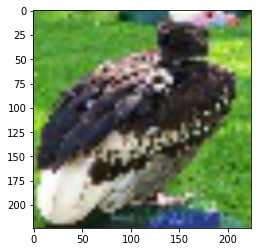

In [ ]:
# try to save a attacked patch
index = 3

clipped_advs[0].shape
labels.shape


img = clipped_advs[0][index].cpu()
img = img.numpy()
img = img.swapaxes(0,1)
img = img.swapaxes(1,2)
plt.imshow(img)


raw = inputs[index].cpu().numpy()
raw = raw.swapaxes(0, 1)
raw = raw.swapaxes(1, 2)
plt.imshow(raw)




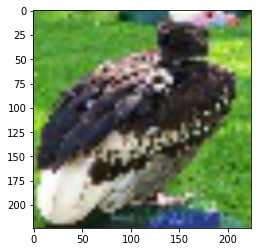

In [ ]:
raw = inputs[index].cpu().numpy()
raw = raw.swapaxes(0, 1)
raw = raw.swapaxes(1, 2)
plt.imshow(raw)

1.0 0.0
1.0 0.003921569
0.100000024 -0.100000024
tensor(True, device='cuda:0')
38.45770397615005
38.458046
tensor(12, device='cuda:0')


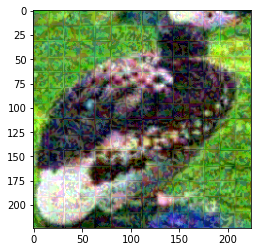

In [ ]:
index= 3
non_clip = raw_advs[0][index].cpu().numpy()
non_clip = non_clip.swapaxes(0, 1)
non_clip = non_clip.swapaxes(1, 2)
plt.imshow(non_clip)

diff = non_clip - raw

print(non_clip.max(), non_clip.min())
print(raw.max(), raw.min())
print(diff.max(), diff.min())
print(success[0][index])


img = clipped_advs[0][index].cpu()
img = img.numpy()
img = img.swapaxes(0,1)
img = img.swapaxes(1,2)

raw = inputs[index].cpu().numpy()
raw = raw.swapaxes(0, 1)
raw = raw.swapaxes(1, 2)
diff = abs(img - raw)

print((diff * diff).sum()**0.5)

print(np.linalg.norm(diff))
print(labels[index])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1.0 0.003921569
1.0 0.0
0.100000024 -0.100000024
tensor(True, device='cuda:0')
tensor([ 9,  0,  4,  0,  9,  5,  6,  0,  2,  5,  0,  7, 15, 13,  7,  7,  0,  7,
         0,  6,  4,  5, 12,  0,  8,  6, 12,  9,  8,  0,  9,  9],
       device='cuda:0')
tensor([12, 13,  2, 12,  1,  4, 14,  0,  9, 14,  9,  9, 12,  5,  5,  0,  5,  7,
         1, 14,  2,  7,  5,  2,  6,  4, 14, 15,  7, 10, 10, 10],
       device='cuda:0')
tensor([12, 13,  2, 12,  1,  4, 14,  0,  9, 14,  9,  9, 12,  5,  5,  0,  5,  7,
         1, 11,  2,  7,  5,  2,  6,  4, 14, 15,  7, 10, 10, 10],
       device='cuda:0')


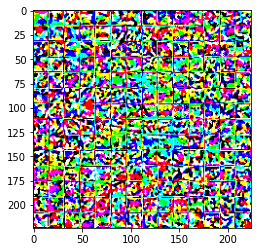

In [ ]:
diff = raw - img
plt.imshow(diff*500)

print(raw.max(), raw.min())
print(img.max(), img.min())
print(diff.max(), diff.min())
print(success[0][index])

adv_pred = model(clipped_advs[0]).argmax(axis=1)
raw_pred = model(inputs).argmax(axis=1)

print(adv_pred)
print(raw_pred)
print(labels)

In [ ]:
print(torch.cuda.memory_cached() / 1024**2)
torch.cuda.empty_cache()
print(torch.cuda.memory_cached() / 1024**2)
print(torch.cuda.memory_summary(device=None, abbreviated=False))
!nvidia-smi

9288.0
9288.0
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 1            |        cudaMalloc retries: 1         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    7644 MB |   14096 MB |   64616 GB |   64608 GB |
|       from large pool |    7640 MB |   14093 MB |   64603 GB |   64595 GB |
|       from small pool |       3 MB |       3 MB |      13 GB |      13 GB |
|---------------------------------------------------------------------------|
| Active memory         |    7644 MB |   14096 MB |   64616 GB |   64608 GB |
|       from large pool |    7640 MB |   14093 MB 

/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:375: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


# New Section

In [ ]:
# load pre-trained vit
model = timm.create_model('vit_base_patch16_224', pretrained=True)
model.eval()


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


torch.Size([1000])


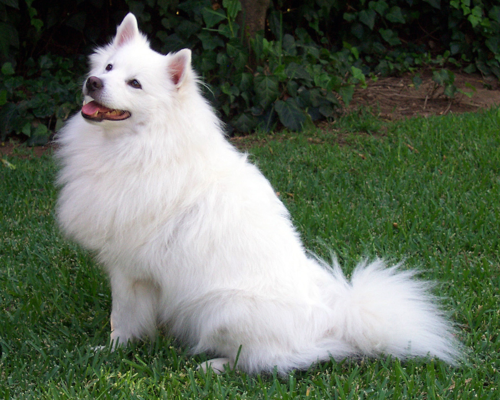

Samoyed 0.59574294090271
Pomeranian 0.22416207194328308
keeshond 0.06150775030255318
Japanese spaniel 0.009464750997722149
Great Pyrenees 0.00902723427861929


In [ ]:
config = resolve_data_config({}, model=model)
transform = create_transform(**config)

url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
urllib.request.urlretrieve(url, filename)
img = Image.open(filename).convert('RGB')
img = img.resize((500, 400))
tensor = transform(img).unsqueeze(0) # transform and add batch dimension

import torch
with torch.no_grad():
    out = model(tensor)
probabilities = torch.nn.functional.softmax(out[0], dim=0)
print(probabilities.shape)

# Get imagenet class mappings
url, filename = ("https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt", "imagenet_classes.txt")
urllib.request.urlretrieve(url, filename) 
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]


from IPython.display import Image, display
display(img)


# Print top categories per image
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())